In [8]:
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler

# Load data
energy_df = pd.read_csv('energy_dataset.csv')

In [9]:

# Preprocess data
def pre_process_totalload(df):
    df["time"] = pd.to_datetime(df["time"], utc=True)
    df.set_index('time', inplace=True)
    df["month"] = df.index.month
    df["weekday"] = df.index.weekday
    df["hour"] = df.index.hour
    df = pd.get_dummies(df, columns=['hour'], dtype=int)
    return df

def check_all_zero(df):
    all_zero_column=[]
    for column in energy_df:
        all_zeros_or_null = (energy_df[column] == 0) | pd.isnull(energy_df[column])
        if all_zeros_or_null.all()==True:
            all_zero_column.append(column)
    return all_zero_column

all_cero_column = check_all_zero(energy_df)


def drop_column(df, columns):
    return df.drop(columns, axis=1)

energy_df =drop_column(energy_df,all_cero_column)


def pre_process(df):
    all_cero_column=check_all_zero(df)
    df= drop_column(df,all_cero_column)
    total_load_df=pre_process_totalload(df)
    print(total_load_df.isnull().values.any())
    return total_load_df

# Apply preprocessing
total_load_df = pre_process_totalload(energy_df)

# Handle missing data
total_load_df.fillna(method='ffill', inplace=True)  # Forward fill NaN values


In [10]:
# Split features and target
y_df = total_load_df["total load actual"].astype('float64')
X_df = total_load_df.drop(["total load actual"], axis=1)

# Normalize features
scaler = StandardScaler()
X_df_scaled = scaler.fit_transform(X_df)

# Check for NaNs after normalization

# Normalize features
X_scaled = scaler.fit_transform(X_df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_df, test_size=0.33, random_state=42)

# Normalize target variable
mean_y_train = y_train.mean()
std_y_train = y_train.std()
y_train_normalized = (y_train - mean_y_train) / std_y_train

sep = '2018-01-01'
mean_train = y_train.mean()
std_train = y_train.std()

y_train_normalized = (y_train - mean_train) / std_train
y_test_normalized = (y_test - mean_train) / std_train



In [11]:
import numpy as np
# Split data into training and testing
print(f"NaNs in X_train: {np.isnan(X_train).any()}")
print(f"NaNs in y_train: {np.isnan(y_train).any()}")


NaNs in X_train: False
NaNs in y_train: False


In [12]:
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l1
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    mu = Dense(1)(x)
    sigma = Dense(1, activation=tf.nn.softplus)(x)
    outputs = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t[0], scale=t[1]))([mu, sigma])
    return Model(inputs, outputs)

model = build_model(X_train.shape[1])

In [21]:
""" # Loss function
def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true) """

negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss=negloglikelihood)

# Train model
history = model.fit(X_train, y_train_normalized, epochs=200, batch_size=62, verbose=1)

""" 

The loss function you are using is the negative log-likelihood (negloglik), which is a common choice for probabilistic models. This function calculates the log probability of the true values according to the predicted distribution and then takes the negative of this value. In probabilistic modeling, the goal is to maximize the log probability of the observed data under the model. Since most optimization algorithms (like gradient descent) are designed to minimize a function, we take the negative of the log-likelihood to turn our maximization problem into a minimization one.

So, a more negative loss means that the model's predicted distribution is getting closer to the true data distribution. This is a good sign that your model is learning. As the model trains and becomes better at predicting the true data distribution, you should expect the negative log-likelihood to decrease (become more negative).

In summary, the negative loss values indicate that your model is learning effectively and is able to increasingly accurately predict the data distribution. This is a normal and expected behavior in probabilistic modeling with negative log-likelihood as the loss function.


"""





Epoch 1/200
379/379 [==============================] - 1s 793us/step - loss: -1.6648
Epoch 2/200
379/379 [==============================] - 0s 650us/step - loss: -1.6626
Epoch 3/200
379/379 [==============================] - 0s 617us/step - loss: -1.6801
Epoch 4/200
379/379 [==============================] - 0s 544us/step - loss: -1.6725
Epoch 5/200
379/379 [==============================] - 0s 582us/step - loss: -1.6781
Epoch 6/200
379/379 [==============================] - 0s 564us/step - loss: -1.6866
Epoch 7/200
379/379 [==============================] - 0s 811us/step - loss: -1.6697
Epoch 8/200
379/379 [==============================] - 0s 524us/step - loss: -1.6783
Epoch 9/200
379/379 [==============================] - 0s 510us/step - loss: -1.6797
Epoch 10/200
379/379 [==============================] - 0s 522us/step - loss: -1.6779
Epoch 11/200
379/379 [==============================] - 0s 507us/step - loss: -1.6842
Epoch 12/200
379/379 [==============================] - 0s 595u

" \n\nThe loss function you are using is the negative log-likelihood (negloglik), which is a common choice for probabilistic models. This function calculates the log probability of the true values according to the predicted distribution and then takes the negative of this value. In probabilistic modeling, the goal is to maximize the log probability of the observed data under the model. Since most optimization algorithms (like gradient descent) are designed to minimize a function, we take the negative of the log-likelihood to turn our maximization problem into a minimization one.\n\nSo, a more negative loss means that the model's predicted distribution is getting closer to the true data distribution. This is a good sign that your model is learning. As the model trains and becomes better at predicting the true data distribution, you should expect the negative log-likelihood to decrease (become more negative).\n\nIn summary, the negative loss values indicate that your model is learning ef

In [14]:
from tensorflow.keras.metrics import MeanSquaredError

# Predict on the test set using the model
distribution_predictions = model.predict(X_test)

# We take the mean of the distribution for point predictions
point_predictions = distribution_predictions.mean()

# Initialize the MSE metric
mse = MeanSquaredError()

# Update state of the metric with true values and predicted values
mse.update_state(y_test, point_predictions)

# Calculate MSE
mean_squared_error = mse.result().numpy()

print(f"Mean Squared Error on the test set: {mean_squared_error}")


362/362 [==============================] - 0s 279us/step
Mean Squared Error on the test set: 842648064.0


In [15]:
print(model)
print(history)

train_loss = history.history['loss']
#val_loss = history.history['val_loss']

print(train_loss)
print(history.history)

[-0.026371082291007042, -0.07599040865898132, -0.08903765678405762, -0.09718557447195053, -0.10025626420974731, -0.10404736548662186, -0.10687516629695892, -0.10790257900953293, -0.10989073663949966, -0.1111241802573204, -0.11190243810415268, -0.11366698890924454, -0.11507632583379745, -0.1158568263053894, -0.11743216216564178, -0.11753107607364655, -0.11913225799798965, -0.12059341371059418, -0.12112914770841599, -0.12179327011108398, -0.12261839956045151, -0.12248814105987549, -0.12383177876472473, -0.12497752159833908, -0.12504546344280243, -0.1258135437965393, -0.12645061314105988, -0.12853892147541046, -0.1276833415031433, -0.12749485671520233, -0.1288079470396042, -0.1289978325366974, -0.13053080439567566, -0.13100765645503998, -0.1315179318189621, -0.13231265544891357, -0.13165801763534546, -0.1331399530172348, -0.13216929137706757, -0.13384687900543213, -0.13417060673236847, -0.13415251672267914, -0.13545437157154083, -0.13543574512004852, -0.13640077412128448, -0.1371883153915

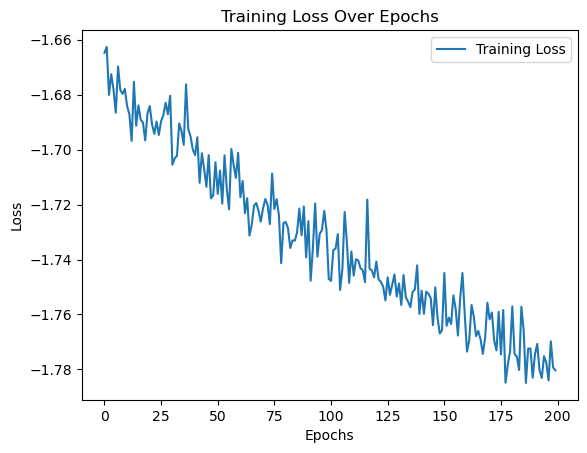

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


362/362 [==============================] - 0s 295us/step


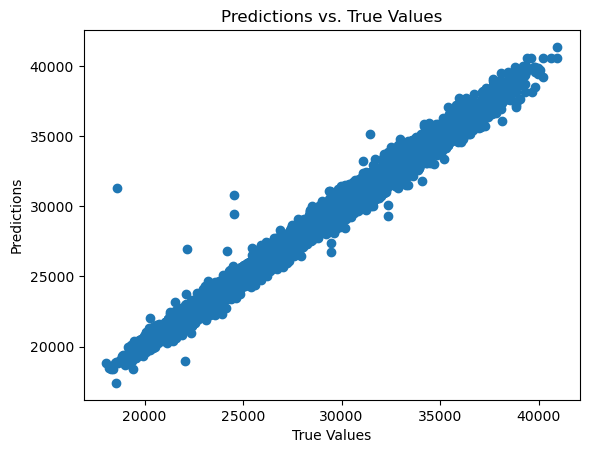

[[25827.639]
 [32826.227]
 [30288.041]
 ...
 [21686.764]
 [28266.453]
 [33453.375]]


In [23]:
predictions = model.predict(X_test)
# Apply inverse transformation to bring predictions back to original scale
predictions = predictions * std_train + mean_train

# Plot predictions vs. targets
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')
plt.show()
#util.plot_pred_scatter(y_test, ts_pred, figsize=figsize)
print(predictions)

In [24]:
# Create a DataFrame with the index of X_test
result_df = pd.DataFrame(index=y_test.index)

# Add columns for predictions and true values
result_df['predictions'] = predictions.flatten()  # Flatten the predictions array
result_df['true_values'] = y_test.values #

In [25]:
result_df

,predictions,true_values
time,,
2015-09-10 21:00:00+00:00,25827.638672,25744.0
2018-09-20 07:00:00+00:00,32826.226562,32484.0
2016-01-04 13:00:00+00:00,30288.041016,31594.0
2015-03-03 18:00:00+00:00,34246.972656,33367.0
2015-06-25 18:00:00+00:00,31951.642578,31727.0
...,...,...
2017-04-25 18:00:00+00:00,30774.726562,30596.0
2017-09-24 05:00:00+00:00,21484.417969,21308.0
2018-03-11 02:00:00+00:00,21686.763672,21848.0


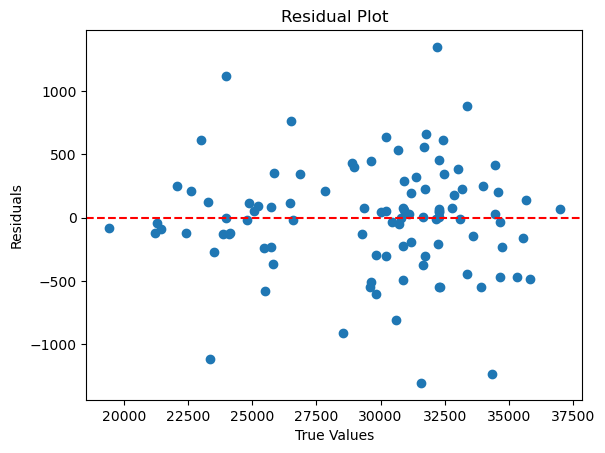

In [26]:


residuals = result_df[0:100]['predictions'] -result_df[0:100]["true_values"]
plt.scatter(result_df[0:100]["true_values"], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
